In [26]:
from scipy.stats import laplace
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Importa o dataset

In [72]:
dataset = pd.read_csv("adult.csv")
dataset.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country,class
0,2,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,1,0,2,United-States,<=50K
1,3,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,0,United-States,<=50K
2,2,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,2,United-States,<=50K
3,3,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,2,United-States,<=50K
4,1,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,2,Cuba,<=50K


## Consultas

* Q1: Média do atributo age
* Q2: Somatório do atributo capital-gain
* Q3: Média do atributo hours-per-week
* Q4: Quantidade de pessoas com income > 50K

In [73]:
def Q1(dataset):
    return dataset.age.mean()

def Q2(dataset):
    return dataset.capitalgain.sum()

def Q3(dataset):
    return dataset.hoursperweek.mean()

def Q4(dataset):
    DatasetProcessado = dataset[dataset["class"] == ">50K"]
    return DatasetProcessado.shape[0]


## Vizinhança


In [74]:
def gerarVizinho(dataset,linhaRemover):
    return dataset.drop([linhaRemover])

def gerarListaVizinhosOtimizado(dataset, f):
    naoMudar = NaoMudar(f)
    unicos = []
    listaTodosVizinhos = []
    for i in range(dataset.shape[0]):
        if(dataset.iloc[i][naoMudar] not in unicos):
            unicos.append(dataset.iloc[i][naoMudar])
            listaTodosVizinhos.append(gerarVizinho(dataset, i))
    return listaTodosVizinhos

In [75]:
def NaoMudar(f):
    if(f==Q1):
        return "age"
    if(f==Q2):
        return "capitalgain"
    if(f==Q3):
        return "hoursperweek"
    if(f==Q4):
        return "capitalgain"
    if(f==f1):
        return "casas"

## Sensibilidade

In [76]:
def calcularSensibilidade(dataset, f, sensibilidadeDatasetOriginal):   
    maiorDiferenca = 0
        
    for vizinho in gerarListaVizinhosOtimizado(dataset, f):
        diferenca = abs(sensibilidadeDatasetOriginal - f(vizinho))
        if maiorDiferenca < diferenca:
            maiorDiferenca = diferenca
            
    return maiorDiferenca

## Laplace

In [77]:
def calcularRuido(delta, budget, u):
    return laplace.rvs(loc=u, scale=delta/budget)

## Apresenta Laplace

In [78]:
# TODO: Calcular o plot que será apresentado
def apresentarDistribuicao(ruido, budgets, u, sensibilidade, funcao):
    t1 = np.arange(0.0, 2.0, 0.1)
    t2 = np.arange(0.0, 2.0, 0.01)

    fig, ax = plt.subplots()

    budget1, = ax.plot(t2, np.exp(-t2))
    budget2, = ax.plot(t2, np.sin(2 * np.pi * t2))
    budget3, = ax.plot(t2, np.exp(-t2) * np.sin(2 * np.pi * t2))

    ax.legend((budget1, budget2, budget3), 
              ('u = {}, b = {}'.format(u, budgets[0]),
               'u = {}, b = {}'.format(u, budgets[1]),
               'u = {}, b = {}'.format(u, budgets[2])), 
              loc='upper right', shadow=True)
    ax.set_xlabel('x')
    ax.set_ylabel('')
    ax.set_title('Consulta {}'.format(funcao))
    plt.show()

## Mecanismo

In [79]:
def calcularResposta(dataset, funcoes, budgets, u):
    resultados = []
    sensibilidades = []
    
    for budget in budgets:
        indiceFuncao = 1
        
        for funcao in funcoes:
            sensibilidadeDatasetOriginal = funcao(dataset)
            delta = calcularSensibilidade(dataset, funcao, sensibilidadeDatasetOriginal)
            
            ruido = calcularRuido(delta, budget/len(funcoes), u)
            
            fD = funcao(dataset)
            resultado = fD + ruido
#             apresentarDistribuicao(ruido, budgets, u, delta, 'Q'+str(indiceFuncao))
            
            print('Budget: {}'.format(budget))
            print('Função: Q{}'.format(indiceFuncao))
            print('Sensibilidade: {}'.format(delta))
            print('F(D): {}'.format(fD))
            print('Ruído: {}'.format(ruido))
            print('Ruído + F(D): {}'.format(resultado))
            
            indiceFuncao += 1
            
            sensibilidades.append(delta)
            resultados.append(resultado)
    
    consultas = ['Q1', 'Q2', 'Q3', 'Q4']
    
    return (budgets, consultas, sensibilidades, resultados)

## Salvando o resultado

In [80]:
def salvarResultados(resultadosLaplace):
    budgets = resultadosLaplace[0]
    consultas = resultadosLaplace[1]
    sensibilidades = resultadosLaplace[2]
    resultados = resultadosLaplace[3]
    resultadoLista = []

    indiceSensibilidade = 0
    for budget in budgets:
        for consulta in consultas:
            resultadoLista.append([budget, consulta, sensibilidades[indiceSensibilidade], resultados[indiceSensibilidade]])
            indiceSensibilidade += 1
    
    resultadoDataframe = pd.DataFrame(resultadoLista, columns=['budget', 'consulta', 'sensibilidade', 'resultado'])
    resultadoDataframe.to_csv('resultado.csv', index=False)
    return resultadoDataframe

In [83]:
def main():
    budgets = [0.1, 1, 10]
    funcoes = [Q1, Q2, Q3, Q4]
    u = 0
    resultados = calcularResposta(dataset, funcoes, budgets, u)
    salvarResultados(resultados)

In [84]:
main()

Budget: 0.1
Função: Q1
Sensibilidade: 4.5636285693984036e-05
F(D): 1.7710781704270915
Ruído: 0.002542475260564579
Ruído + F(D): 1.773620645687656
Budget: 0.1
Função: Q2
Sensibilidade: 4
F(D): 9784
Ruído: 24.66744706942116
Ruído + F(D): 9808.667447069422
Budget: 0.1
Função: Q3
Sensibilidade: 4.19586378328507e-05
F(D): 1.9506981696081243
Ruído: 0.001255937273637359
Ruído + F(D): 1.9519541068817616
Budget: 0.1
Função: Q4
Sensibilidade: 1
F(D): 11687
Ruído: -56.70824908563497
Ruído + F(D): 11630.291750914364
Budget: 1
Função: Q1
Sensibilidade: 4.5636285693984036e-05
F(D): 1.7710781704270915
Ruído: 0.00019940160934180662
Ruído + F(D): 1.7712775720364333
Budget: 1
Função: Q2
Sensibilidade: 4
F(D): 9784
Ruído: 11.443609813635629
Ruído + F(D): 9795.443609813636
Budget: 1
Função: Q3
Sensibilidade: 4.19586378328507e-05
F(D): 1.9506981696081243
Ruído: 3.6251886141028505e-05
Ruído + F(D): 1.9507344214942652
Budget: 1
Função: Q4
Sensibilidade: 1
F(D): 11687
Ruído: 5.885583983853598
Ruído + F(D): 11

## Exemplo slide

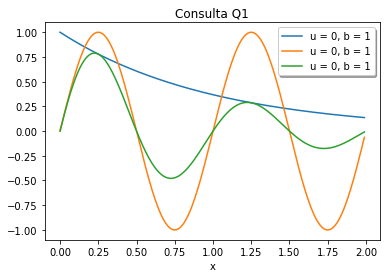

Budget: 1
Função: Q1
Sensibilidade: 7
Ruído: -4.67758426416373
Ruído + F(D): 9.32241573583627


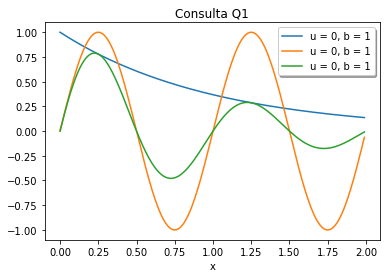

Budget: 1
Função: Q1
Sensibilidade: 7
Ruído: -6.030606270126892
Ruído + F(D): 7.969393729873108


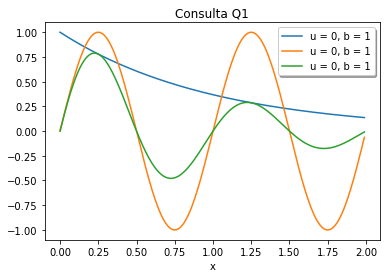

Budget: 1
Função: Q1
Sensibilidade: 7
Ruído: -10.462483618807525
Ruído + F(D): 3.537516381192475


([1, 1, 1],
 ['Q1', 'Q2', 'Q3', 'Q4'],
 [7, 7, 7],
 [9.32241573583627, 7.969393729873108, 3.537516381192475])

In [12]:
d = {'nome': ["z", "s","g","l"], 'casas': [4,2,7,1]}

def f1(dataset):
    return dataset.casas.sum()

df = pd.DataFrame(data=d)

calcularResposta(df, [f1], [1, 1, 1], 0)